### Questions:

- Why are there missing values in sequence ID for some pairs?
- Are these just the subset that were sampled for Y2H?
- How exactly were the pairs selected

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from data_loading import (load_isoform_and_paralog_y2h_data,
                          load_paralog_pairs,
                          load_valid_isoform_clones)

In [2]:
y2h = load_isoform_and_paralog_y2h_data()
pairs = load_paralog_pairs()
valid_clones = load_valid_isoform_clones()

In [3]:
print(pairs.shape)
pairs.head()

(148, 4)


,tf_gene_a,tf_gene_b,is_paralog_pair,pct_aa_seq_identity
0,ZNF18,ZNF263,True,28.9
1,ZNF24,ZNF394,True,30.5
2,ZSCAN21,ZSCAN9,True,37.3
3,LHX8,LHX9,True,30.0
4,ELF2,ETV6,True,10.7


In [4]:
pairs['is_paralog_pair'].value_counts()

True     132
False     16
Name: is_paralog_pair, dtype: int64

In [5]:
pairs.isnull().sum()

tf_gene_a              0
tf_gene_b              0
is_paralog_pair        0
pct_aa_seq_identity    9
dtype: int64

In [6]:
pairs.loc[pairs['pct_aa_seq_identity'].isnull(), :]

,tf_gene_a,tf_gene_b,is_paralog_pair,pct_aa_seq_identity
15,NR2F2,RXRB,True,NaN
18,RXRB,RXRG,True,NaN
28,HNF4A,RXRB,True,NaN
30,TEAD2,TEAD3,True,NaN
36,TEAD1,TEAD3,True,NaN
67,RXRA,RXRB,True,NaN
73,TEAD3,TEAD4,True,NaN
81,TEAD1,TEAD2,True,NaN
98,TEAD1,TEAD4,True,NaN


In [7]:
pairs.shape

(148, 4)

In [8]:
pairs.loc[~pairs['is_paralog_pair'], :]

,tf_gene_a,tf_gene_b,is_paralog_pair,pct_aa_seq_identity
133,GLIS2,PCGF6,False,2.2
134,NFIX,TCF4,False,10.1
135,FOSB,PATZ1,False,12.0
136,ELF2,NFYA,False,7.7
137,HMBOX1,TFCP2,False,7.7
138,HOXA1,ZNF131,False,3.5
139,ZBTB48,ZIC3,False,15.7
140,NFIX,NR2F2,False,5.1
142,GRHL3,SPIB,False,5.8
144,REL,RFX4,False,12.8


In [9]:
print(pairs.shape)
print(pairs['is_paralog_pair'].value_counts())

(148, 4)
True     132
False     16
Name: is_paralog_pair, dtype: int64


In [10]:
from collections import Counter

counts = pd.Series(Counter(pairs[['tf_gene_a', 'tf_gene_b']].values.flatten()))

In [11]:
print(counts.shape)
counts.value_counts().sort_index()

(109,)


1     43
2     21
3     14
4     16
6      8
7      3
8      2
9      1
11     1
dtype: int64

In [12]:
counts.sort_values(ascending=False).head()

RARG     11
RXRA      9
ESRRA     8
HNF4A     8
PPARG     7
dtype: int64

In [13]:
# add matched_gene column to y2h table
y2h_paralog = y2h.loc[y2h['category'].isin(['tf_paralog_ppis',
                                            'paralog_with_PDI',
                                            'non_paralog_control']), :].copy()
y2h_paralog.head()

,large_plate_name,retest_pla,retest_pos,ad_gene_symbol,ad_clone_name,ad_orf_id,db_gene_symbol,db_orf_id,category,3AT,LW,empty_AD_3AT,empty_AD_LW,Y2H_result,seq_confirmation_3AT,seq_confirmation_LW,ad_clone_acc
1,TFfnlr07_001_002_003_004_005_006,5,A02,ATF2,ATF2-1,101414,COL8A1,3053,tf_paralog_ppis,0,4,0,4,False,NaN,True,ATF2|1/6|12H04
2,TFfnlr07_001_002_003_004_005_006,5,A03,ATF2,ATF2-1,101414,EFEMP2,2906,tf_paralog_ppis,0,4,0,4,False,NaN,True,ATF2|1/6|12H04
13,TFfnlr07_001_002_003_004_005_006,5,B02,ATF2,ATF2-2,101256,COL8A1,3053,tf_paralog_ppis,0,4,0,4,False,NaN,True,ATF2|2/6|09E05
14,TFfnlr07_001_002_003_004_005_006,5,B03,ATF2,ATF2-2,101256,EFEMP2,2906,tf_paralog_ppis,0,4,0,4,False,NaN,True,ATF2|2/6|09E05
25,TFfnlr07_001_002_003_004_005_006,5,C02,ATF2,ATF2-3,101254,COL8A1,3053,tf_paralog_ppis,0,4,0,4,False,NaN,True,ATF2|3/6|09C05


In [14]:
from collections import defaultdict
pair_map = defaultdict(set)
for _i, row in pairs.iterrows():
    a, b = row['tf_gene_a'], row['tf_gene_b']
    pair_map[a].add(b)
    pair_map[b].add(a)

In [15]:
def find_matching_gene(row):
    matches = pair_map[row['ad_gene_symbol']]
    matches = set(y2h.loc[(y2h['category'] == 'tf_isoform_ppis') &
            y2h['ad_gene_symbol'].isin(matches) &
            (y2h['db_gene_symbol'] == row['db_gene_symbol']), 
            'ad_gene_symbol'].unique())
    if len(matches) == 0:
        return np.nan
    else:
        return '|'.join(matches)


y2h_paralog['paired_tf_gene'] = y2h_paralog.apply(find_matching_gene, axis=1)

In [16]:
def matches_a_positive(row):
    matches = pair_map[row['ad_gene_symbol']]
    matches = set(y2h.loc[(y2h['category'] == 'tf_isoform_ppis') &
            y2h['ad_gene_symbol'].isin(matches) &
            (y2h['Y2H_result'] == True) &
            (y2h['db_gene_symbol'] == row['db_gene_symbol']), 
            'ad_gene_symbol'].unique())
    return len(matches) > 0

y2h_paralog['matches_positive'] = y2h_paralog.apply(matches_a_positive, axis=1)

In [17]:
y2h_paralog['paired_tf_gene'].isnull().value_counts()

False    4207
Name: paired_tf_gene, dtype: int64

In [18]:
y2h_paralog['matches_positive'].value_counts()

True     3166
False    1041
Name: matches_positive, dtype: int64

In [19]:
gte2iso = (y2h.loc[y2h['category'] == 'tf_isoform_ppis', :]
              .groupby('ad_gene_symbol')['ad_clone_acc']
              .nunique() >= 2)
gte2iso = set(gte2iso.index[gte2iso])
y2h_paralog['at_least_2_isoforms'] = (y2h_paralog['ad_gene_symbol'].isin(gte2iso) &
                                      y2h_paralog['paired_tf_gene'].apply(lambda x: any(g in gte2iso for g in x.split('|')) if pd.notnull(x) else False))

In [20]:
gte2partner = (y2h.loc[y2h['category'] == 'tf_isoform_ppis', :]
                  .groupby('ad_gene_symbol')['db_gene_symbol']
                  .nunique() >= 2)
gte2partner = set(gte2partner.index[gte2partner])
y2h_paralog['at_least_2_partners'] = (y2h_paralog['ad_gene_symbol'].isin(gte2partner) &
                                      y2h_paralog['paired_tf_gene'].apply(lambda x: any(g in gte2partner for g in x.split('|')) if pd.notnull(x) else False))

In [21]:
y2h_paralog['at_least_2_partners'].value_counts()

True    4207
Name: at_least_2_partners, dtype: int64

In [22]:
non_zero_iso = set(y2h.loc[y2h['category'].isin(['tf_isoform_ppis', 
                                            'tf_paralog_ppis',
                                            'paralog_with_PDI',
                                            'non_paralog_control'])
                       & (y2h['Y2H_result'] == True), 
                        'ad_clone_acc'].unique())

In [23]:
def numbers_per_cutoff(df):
    return {'N PPI': df.shape[0],
            'N TF genes': df['ad_gene_symbol'].nunique(),
            'N TF isoforms': df['ad_clone_acc'].nunique(),
            'N PPI partners': df['db_gene_symbol'].nunique()}

filtered_datasets = {'Originally tested': 
                    y2h_paralog,
                    'Matches current clones and isoform PPIs':
                    y2h_paralog.loc[y2h_paralog['paired_tf_gene'].notnull(), :],
              'At least two isoforms per TF gene': 
              y2h_paralog.loc[y2h_paralog['paired_tf_gene'].notnull() &
                  y2h_paralog['at_least_2_isoforms'], :],
              'At least two partners per TF gene': 
                y2h_paralog.loc[y2h_paralog['paired_tf_gene'].notnull() &
                                y2h_paralog['at_least_2_isoforms'] &
                                y2h_paralog['at_least_2_partners'], :],
            'Positive with one of isoforms of paired paralog gene': 
                y2h_paralog.loc[y2h_paralog['paired_tf_gene'].notnull() &
                                y2h_paralog['at_least_2_isoforms'] &
                                y2h_paralog['at_least_2_partners'] &
                                y2h_paralog['matches_positive'], :],
              'At least one positive per isoform': 
                y2h_paralog.loc[y2h_paralog['paired_tf_gene'].notnull() &
                                y2h_paralog['at_least_2_isoforms'] &
                                y2h_paralog['at_least_2_partners'] &
                                y2h_paralog['matches_positive'] &
                                y2h_paralog['ad_clone_acc'].isin(non_zero_iso), :],
               }


pd.DataFrame({k: numbers_per_cutoff(v) for k, v in filtered_datasets.items()}).T

,N PPI,N TF genes,N TF isoforms,N PPI partners
Originally tested,4207,72,207,551
Matches current clones and isoform PPIs,4207,72,207,551
At least two isoforms per TF gene,4207,72,207,551
At least two partners per TF gene,4207,72,207,551
Positive with one of isoforms of paired paralog gene,3166,69,200,430
At least one positive per isoform,2325,66,142,428


In [24]:
# pairs that come from lit-bm testing negative: e.g. REL tested against RNF25 from parlog RELA


# NFIX tested against ZBTB25


# nothing for TSC22D4?
# perhaps clones all failed?


#y2h.loc[y2h['ad_gene_symbol'].isin(pair_map['NFIX']) &
#        (y2h['db_gene_symbol'] == 'ZBTB25'), :]
#y2h.loc[(y2h['db_gene_symbol'] == 'ZBTB25'), :]
y2h.loc[y2h['ad_gene_symbol'].isin(pair_map['NFIX']), 'ad_gene_symbol'].unique()

array(['NR2F2', 'NFIA', 'TCF4'], dtype=object)

In [25]:
from data_loading import load_valid_isoform_clones
clones = load_valid_isoform_clones()

In [26]:
clones.head()

,gene,clone_acc,cds,aa_seq,num_aa,is_novel_isoform,clone_name
0,AEBP2,AEBP2|2/3|05F03,ATGGATGTAGACAGCACAATTTCCAGTGGGCGTTCAACTCCAGCAA...,MDVDSTISSGRSTPAMMNGQGSTTSSSKNIAYNCCWDQCQACFNSS...,268,True,AEBP2-2
1,AEBP2,AEBP2|3/3|05E07,ATGTACACACGTCGGTACTCAAGCATAAGCAGTACTATAATGGATG...,MYTRRYSSISSTIMDVDSTISSGRSTPAMMNGQGSTTSSSKNIAYN...,263,True,AEBP2-3
2,ARNT2,ARNT2|1/6|08C12,ATGGCAACCCCGGCGGCGGTCAACCCTCCGGAAATGGCTTCAGACA...,MATPAAVNPPEMASDIPGSVTLPVAPMAATGQVRMAGAMPARGGKR...,717,False,ARNT2-1
3,ARNT2,ARNT2|2/6|09E01,ATGGCTTCAGACATACCTGGATCTGTGACGTTGCCCGTTGCCCCCA...,MASDIPGSVTLPVAPMAATGQVRMAGAMPARGGKRRSGMDFDDEDG...,683,True,ARNT2-2
4,ARNT2,ARNT2|3/6|10D11,ATGGCAACCCCGGCGGCGGTCAACCCTCCGGAAATGGCTTCAGACA...,MATPAAVNPPEMASDIPGSVTLPVAPMAATGQVRMAGAMPARGGKR...,716,False,ARNT2-3


In [27]:
print(pairs.shape[0])
print((pairs['tf_gene_a'].isin(clones['gene'].unique()) & 
       pairs['tf_gene_b'].isin(clones['gene'].unique())).sum())

148
148


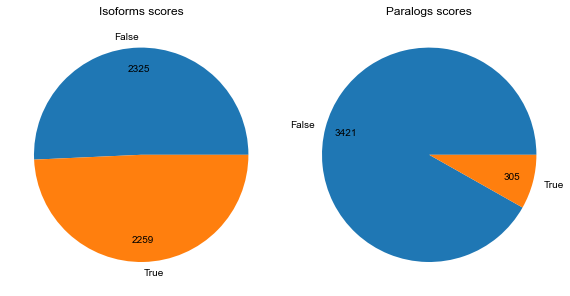

In [28]:
# do we find PPIs for every pair?


fig, axs = plt.subplots(1, 2)
fig.set_size_inches(8, 4)

counts = y2h.loc[(y2h['category'] == 'tf_isoform_ppis'), 'Y2H_result'].value_counts().sort_index()

def absolute_value(val):
    return int(np.round(val / 100. * counts.sum(), 0))

counts.plot.pie(autopct=absolute_value, ax=axs[0],
                pctdistance=0.8)

counts = y2h.loc[y2h['category'].isin(['tf_paralog_ppis', 'paralog_with_PDI', 'non_paralog_control']), 'Y2H_result'].value_counts().sort_index()

def absolute_value(val):
    return int(np.round(val / 100. * counts.sum(), 0))

counts.plot.pie(autopct=absolute_value, ax=axs[1],
                pctdistance=0.8)

axs[0].set_title('Isoforms scores')
axs[1].set_title('Paralogs scores')
for ax in axs:
    ax.set_ylabel('')
plt.savefig('../figures/Y2H_scores-by-experiment_pie.pdf',
            bbox_inches='tight')

In [29]:
y2h.loc[y2h['category'].isin(['tf_paralog_ppis', 'paralog_with_PDI', 'non_paralog_control']) &
        (y2h['Y2H_result'] == True), 'ad_gene_symbol'].value_counts()

TCF12     130
TCF4       49
SOX6       31
TFCP2      16
MEIS1      12
MEIS2       8
ESRRG       6
SOX5        6
PKNOX1      5
ZNF397      4
ZNF18       4
PATZ1       4
ZBTB16      4
LHX9        2
HMBOX1      2
HNF4A       2
FOSB        2
ELF2        2
MEOX1       2
ARNT2       2
ZBTB32      1
ESRRA       1
ZNF263      1
ZBTB18      1
NFIX        1
NPAS2       1
PBX1        1
RARG        1
FOS         1
ZBTB25      1
TEAD2       1
DDIT3       1
Name: ad_gene_symbol, dtype: int64

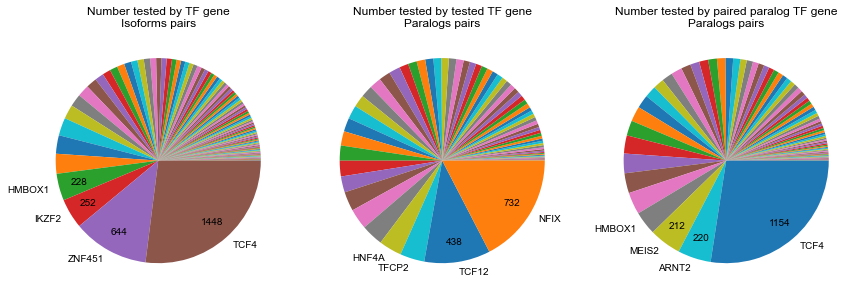

In [30]:
# pie chart by gene
# add another for matched gene for paralogs
fig, axs = plt.subplots(1, 3)
fig.set_size_inches(12, 4)

counts = y2h.loc[(y2h['category'] == 'tf_isoform_ppis'), 'ad_gene_symbol'].value_counts().sort_values()

def absolute_value(val):
    s = int(np.round(val / 100. * counts.sum(), 0))
    if s >= 200:
        return s
    else:
        return ''

counts.plot.pie(autopct=absolute_value, ax=axs[0],
                pctdistance=0.8,
                labels=[i if i in counts.index[-4:] else '' for i in counts.index ],)

counts = y2h.loc[y2h['category'].isin(['tf_paralog_ppis', 'paralog_with_PDI', 'non_paralog_control']), 'ad_gene_symbol'].value_counts().sort_values()

def absolute_value(val):
    s = int(np.round(val / 100. * counts.sum(), 0))
    if s >= 200:
        return s
    else:
        return ''


counts.plot.pie(autopct=absolute_value, ax=axs[1],
                labels=[i if i in counts.index[-4:] else '' for i in counts.index ],
                pctdistance=0.8)

counts = y2h_paralog.loc[:, 'paired_tf_gene'].value_counts().sort_values()

def absolute_value(val):
    s = int(np.round(val / 100. * counts.sum(), 0))
    if s >= 200:
        return s
    else:
        return ''

counts.plot.pie(autopct=absolute_value, ax=axs[2],
                labels=[i if i in counts.index[-4:] else '' for i in counts.index ],
                pctdistance=0.8)

axs[0].set_title('Number tested by TF gene\nIsoforms pairs')
axs[1].set_title('Number tested by tested TF gene\nParalogs pairs')
axs[2].set_title('Number tested by paired paralog TF gene\nParalogs pairs')
for ax in axs:
    ax.set_ylabel('')
plt.savefig('../figures/Y2H_N-PPIs-tested-by-TF-gene_pie.pdf',
            bbox_inches='tight')

In [31]:
valid_clones.groupby('gene').size().value_counts().sort_index()

1     63
2    136
3     60
4     30
5      9
6      8
7      2
8      2
dtype: int64

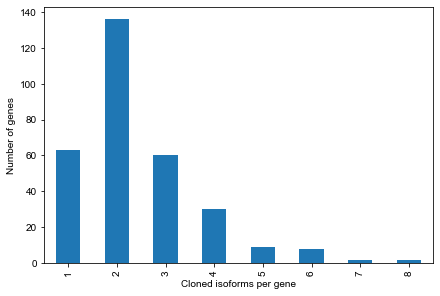

In [32]:
valid_clones.groupby('gene').size().value_counts().sort_index().plot.bar()
plt.ylabel('Number of genes')
plt.xlabel('Cloned isoforms per gene')
plt.savefig('../figures/n-cloned-isoforms-per-gene_bar.pdf',
            bbox_inches='tight')

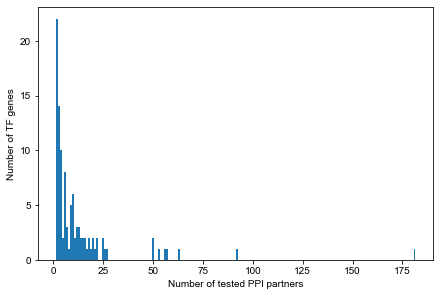

In [33]:
# look at Y2H degree of each gene
fig, ax = plt.subplots(1, 1)
vals = y2h.loc[y2h['category'] == 'tf_isoform_ppis', :].groupby('ad_gene_symbol')['db_gene_symbol'].nunique().value_counts().sort_index()
ax.bar(vals.index, vals.values)
ax.set_ylabel('Number of TF genes')
ax.set_xlabel('Number of tested PPI partners')
plt.savefig('../figures/n-ppi-partners-per-tf-gene_bar.pdf',
            bbox_inches='tight')

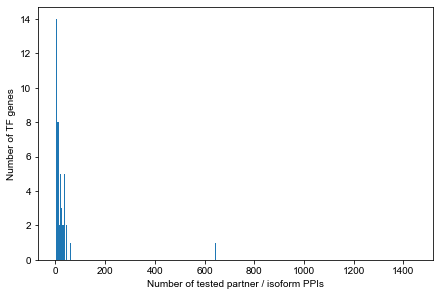

In [34]:
fig, ax = plt.subplots(1, 1)
vals = y2h.loc[y2h['category'] == 'tf_isoform_ppis', :].groupby('ad_gene_symbol').size().value_counts().sort_index()
ax.bar(vals.index, vals.values)
ax.set_ylabel('Number of TF genes')
ax.set_xlabel('Number of tested partner / isoform PPIs')
ax.set_ylim()
plt.savefig('../figures/n-ppi-combinations-per-tf-gene_bar.pdf',
            bbox_inches='tight')

In [35]:
y2h.loc[y2h['category'] == 'tf_isoform_ppis', :].groupby('ad_gene_symbol').size().sort_values(ascending=False).to_frame().rename(columns={0: 'Number of tested partner/isoform PPIs'}).head(10)

,Number of tested partner/isoform PPIs
ad_gene_symbol,
TCF4,1448
ZNF451,644
IKZF2,252
HMBOX1,228
MEOX1,168
SOX6,156
TCF12,150
ZBTB44,120
ZBTB32,106


In [36]:
(y2h.loc[y2h['category'] == 'tf_isoform_ppis', :].groupby('ad_gene_symbol').size() <= 12).value_counts()

False    59
True     47
dtype: int64

In [37]:
y2h.loc[(y2h['ad_gene_symbol'] == 'TCF4') &
        (y2h['category'].isin(['tf_paralog_ppis', 'paralog_with_PDI', 'non_paralog_control'])), :].groupby('ad_clone_acc')['Y2H_result'].value_counts()

ad_clone_acc    Y2H_result
TCF4|1/9|07E01  True           9
                False          6
TCF4|2/9|07E03  True           9
                False          6
TCF4|3/9|07C04  True           8
                False          6
TCF4|4/9|07G02  True           9
                False          7
TCF4|5/9|07C02  False         11
                True           5
TCF4|6/9|07H03  False         14
                True           1
TCF4|7/9|07G03  False         10
                True           5
TCF4|8/9|07A05  False         12
                True           3
Name: Y2H_result, dtype: int64

In [38]:
y2h.loc[(y2h['category'].isin(['tf_paralog_ppis', 'paralog_with_PDI', 'non_paralog_control']))
        & (y2h['Y2H_result'] == True),
        'ad_clone_acc'].value_counts().head(10)

TCF12|1/3|07D07    74
TCF12|2/3|07A09    51
TFCP2|1/3|03E08    16
MEIS1|1/2|09A04    12
TCF4|4/9|07G02      9
TCF4|2/9|07E03      9
TCF4|1/9|07E01      9
TCF4|3/9|07C04      8
SOX6|6/7|07F08      7
SOX6|5/7|07A07      7
Name: ad_clone_acc, dtype: int64

In [39]:
tfs = y2h.loc[(y2h['category'].isin(['tf_paralog_ppis', 'paralog_with_PDI', 'non_paralog_control']))
        & (y2h['Y2H_result'] == True),
        'ad_clone_acc'].value_counts()
tfs = tfs.to_frame().rename(columns={'ad_clone_acc': 'n_positive'})
tfs['n_tested']  = y2h.loc[(y2h['category'].isin(['tf_paralog_ppis', 'paralog_with_PDI', 'non_paralog_control']))
        & y2h['Y2H_result'].notnull(),
        'ad_clone_acc'].value_counts()
tfs['rate'] = tfs['n_positive'] / tfs['n_tested']
tfs.sort_values('rate', ascending=False).head(20)

,n_positive,n_tested,rate
SOX6|6/7|07F08,7,7,1.000000
SOX6|7/7|07C07,6,6,1.000000
SOX6|5/7|07A07,7,7,1.000000
SOX6|2/7|07E06,7,9,0.777778
MEIS1|1/2|09A04,12,16,0.750000
SOX6|1/7|07C06,4,6,0.666667
TCF4|2/9|07E03,9,15,0.600000
TCF4|1/9|07E01,9,15,0.600000
TCF12|1/3|07D07,74,128,0.578125
TCF4|3/9|07C04,8,14,0.571429


In [40]:
tfs.loc[tfs.index.str.startswith('TCF4')].sort_index()

,n_positive,n_tested,rate
TCF4|1/9|07E01,9,15,0.600000
TCF4|2/9|07E03,9,15,0.600000
TCF4|3/9|07C04,8,14,0.571429
TCF4|4/9|07G02,9,16,0.562500
TCF4|5/9|07C02,5,16,0.312500
TCF4|6/9|07H03,1,15,0.066667
TCF4|7/9|07G03,5,15,0.333333
TCF4|8/9|07A05,3,15,0.200000
